# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01   63% |████████████████████▎           | 9.3MB 50.0MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

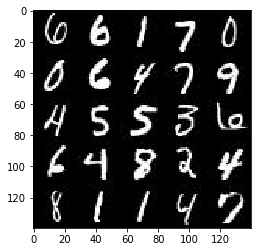

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

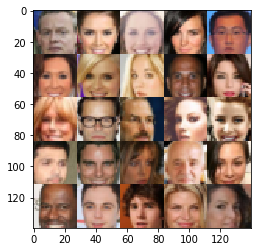

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # create the placeholders for the model
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    # return the placeholders
    return inputs_real, inputs_z, learning_rate

    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28xchannels
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        l1 = tf.maximum(alpha * l1, l1)
        
        # 14x14x64
        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(alpha * l2, l2)

        # 7x7x128
        l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(alpha * l3, l3)
        
        # 4x4x256
        l4 = tf.reshape(l3, (-1, 4*4*256))
        logits = tf.layers.dense(l4, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param reuse: reuse variables
    :param alpha: leaky relu alpha value
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # start with a fully connected layer
        l1 = tf.layers.dense(z, 4*4*512)
        
        # reshape it for a convolutional stack
        l1 = tf.reshape(l1, (-1, 4, 4, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        
        # 4x4x512
        # formula for converting 4x4 input to 7x7 output discovered on forum
        l2 = tf.layers.conv2d_transpose(l1, 256, 4, strides=1, padding='valid')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        
        # 7x7x256
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        
        # 14x14x128
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
        # 28x28xchannels
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, smoothing = 0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real) * smoothing))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
from matplotlib import pyplot as plt

def plot_losses(d_loss, g_loss):
    """
    Plot the discriminator and generator losses on the same graph
    :param d_loss: list of loss values for the discriminator
    :param g_loss: list of loss values for the generator
    """
    fig, ax = plt.subplots()
    plt.plot(d_loss, label='Discriminator', alpha=0.5)
    plt.plot(g_loss, label='Generator', alpha=0.5)
    plt.title("Training Loss")
    plt.legend()

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    real_inputs, z_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_no = 0

    d_losses = []
    g_losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_no += 1
                
                # scale batch images to [-1.0, 1.0]
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                
                # show loss every 10 steps
                if batch_no % 10 == 0: 

                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({z_inputs: batch_z, lr: learning_rate})
                    d_losses.append(train_loss_d)
                    g_losses.append(train_loss_g)
                    print("Epoch {}/{}: batch {}: discriminator loss: {:.4f} generator loss: {:.4f}".format(
                         epoch_i+1, epoch_count, batch_no, train_loss_d, train_loss_g))
                
                # show generator output every 100
                if batch_no % 100 == 0: 
                    show_generator_output(sess, 25, z_inputs, data_shape[-1], data_image_mode)

        # show the final output if the batches don't mod out evenly
        show_generator_output(sess, 25, z_inputs, data_shape[-1], data_image_mode)
        return d_losses, g_losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2: batch 10: descriminator loss: 1.1217 generator loss: 0.7701
Epoch 1/2: batch 20: descriminator loss: 1.1240 generator loss: 16.0016
Epoch 1/2: batch 30: descriminator loss: 0.4641 generator loss: 5.6587
Epoch 1/2: batch 40: descriminator loss: 0.8244 generator loss: 8.9127
Epoch 1/2: batch 50: descriminator loss: 0.7261 generator loss: 2.9220
Epoch 1/2: batch 60: descriminator loss: 1.0819 generator loss: 1.0443
Epoch 1/2: batch 70: descriminator loss: 0.4453 generator loss: 6.5507
Epoch 1/2: batch 80: descriminator loss: 0.5294 generator loss: 3.8244
Epoch 1/2: batch 90: descriminator loss: 0.4394 generator loss: 3.2132
Epoch 1/2: batch 100: descriminator loss: 0.4063 generator loss: 3.5607


Epoch 1/2: batch 110: descriminator loss: 0.3678 generator loss: 4.7739
Epoch 1/2: batch 120: descriminator loss: 0.3756 generator loss: 4.0138
Epoch 1/2: batch 130: descriminator loss: 0.4014 generator loss: 4.7493
Epoch 1/2: batch 140: descriminator loss: 0.4177 generator loss: 3.5456
Epoch 1/2: batch 150: descriminator loss: 0.4006 generator loss: 5.5703
Epoch 1/2: batch 160: descriminator loss: 0.4849 generator loss: 2.6545
Epoch 1/2: batch 170: descriminator loss: 1.3000 generator loss: 11.2658
Epoch 1/2: batch 180: descriminator loss: 0.6654 generator loss: 1.9910
Epoch 1/2: batch 190: descriminator loss: 0.4774 generator loss: 2.9803
Epoch 1/2: batch 200: descriminator loss: 0.7531 generator loss: 4.8365


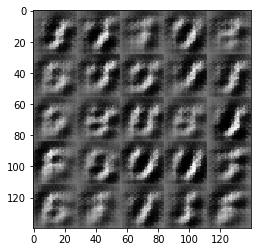

Epoch 1/2: batch 210: descriminator loss: 0.5531 generator loss: 2.3781
Epoch 1/2: batch 220: descriminator loss: 1.2691 generator loss: 0.7532
Epoch 1/2: batch 230: descriminator loss: 0.5764 generator loss: 2.0665
Epoch 1/2: batch 240: descriminator loss: 0.7361 generator loss: 1.7596
Epoch 1/2: batch 250: descriminator loss: 1.0272 generator loss: 0.9004
Epoch 1/2: batch 260: descriminator loss: 0.9999 generator loss: 1.0378
Epoch 1/2: batch 270: descriminator loss: 0.7641 generator loss: 2.5568
Epoch 1/2: batch 280: descriminator loss: 0.7775 generator loss: 3.3268
Epoch 1/2: batch 290: descriminator loss: 0.7707 generator loss: 2.1504
Epoch 1/2: batch 300: descriminator loss: 0.9240 generator loss: 1.3847


Epoch 1/2: batch 310: descriminator loss: 1.0247 generator loss: 1.6790
Epoch 1/2: batch 320: descriminator loss: 0.8190 generator loss: 1.3077
Epoch 1/2: batch 330: descriminator loss: 0.8501 generator loss: 2.1747
Epoch 1/2: batch 340: descriminator loss: 1.0897 generator loss: 0.8014
Epoch 1/2: batch 350: descriminator loss: 0.9132 generator loss: 1.0724
Epoch 1/2: batch 360: descriminator loss: 0.9171 generator loss: 1.2998
Epoch 1/2: batch 370: descriminator loss: 0.8856 generator loss: 1.2062
Epoch 1/2: batch 380: descriminator loss: 1.1954 generator loss: 0.7204
Epoch 1/2: batch 390: descriminator loss: 0.9581 generator loss: 1.3000
Epoch 1/2: batch 400: descriminator loss: 1.1045 generator loss: 0.8262


Epoch 1/2: batch 410: descriminator loss: 1.0618 generator loss: 1.4673
Epoch 1/2: batch 420: descriminator loss: 1.0990 generator loss: 1.0122
Epoch 1/2: batch 430: descriminator loss: 1.0166 generator loss: 1.1290
Epoch 1/2: batch 440: descriminator loss: 0.9246 generator loss: 1.5416
Epoch 1/2: batch 450: descriminator loss: 1.3148 generator loss: 2.4982
Epoch 1/2: batch 460: descriminator loss: 1.0295 generator loss: 0.9524
Epoch 2/2: batch 470: descriminator loss: 1.0322 generator loss: 1.0377
Epoch 2/2: batch 480: descriminator loss: 1.0188 generator loss: 0.8944
Epoch 2/2: batch 490: descriminator loss: 0.9968 generator loss: 1.0812
Epoch 2/2: batch 500: descriminator loss: 0.9680 generator loss: 1.3660


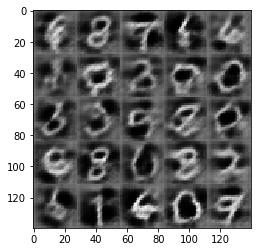

Epoch 2/2: batch 510: descriminator loss: 1.0627 generator loss: 1.1885
Epoch 2/2: batch 520: descriminator loss: 1.0081 generator loss: 1.0964
Epoch 2/2: batch 530: descriminator loss: 1.0382 generator loss: 1.2912
Epoch 2/2: batch 540: descriminator loss: 1.0546 generator loss: 1.4199
Epoch 2/2: batch 550: descriminator loss: 0.9868 generator loss: 1.1384
Epoch 2/2: batch 560: descriminator loss: 1.1135 generator loss: 1.8297
Epoch 2/2: batch 570: descriminator loss: 1.0093 generator loss: 1.5672
Epoch 2/2: batch 580: descriminator loss: 1.1754 generator loss: 0.6741
Epoch 2/2: batch 590: descriminator loss: 1.0371 generator loss: 1.5714
Epoch 2/2: batch 600: descriminator loss: 0.9120 generator loss: 1.3262


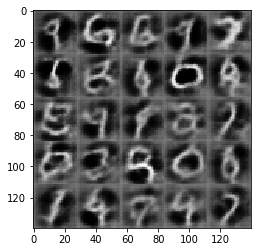

Epoch 2/2: batch 610: descriminator loss: 1.0727 generator loss: 0.9597
Epoch 2/2: batch 620: descriminator loss: 1.0749 generator loss: 0.8147
Epoch 2/2: batch 630: descriminator loss: 1.8072 generator loss: 3.1032
Epoch 2/2: batch 640: descriminator loss: 1.0106 generator loss: 1.0920
Epoch 2/2: batch 650: descriminator loss: 1.1251 generator loss: 0.7871
Epoch 2/2: batch 660: descriminator loss: 1.0777 generator loss: 1.7853
Epoch 2/2: batch 670: descriminator loss: 0.9757 generator loss: 0.9740
Epoch 2/2: batch 680: descriminator loss: 1.2057 generator loss: 2.3854
Epoch 2/2: batch 690: descriminator loss: 1.7985 generator loss: 2.7910
Epoch 2/2: batch 700: descriminator loss: 1.1163 generator loss: 0.9704


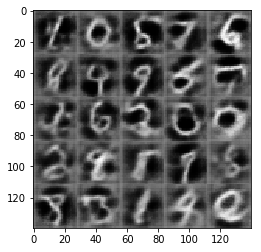

Epoch 2/2: batch 710: descriminator loss: 0.9624 generator loss: 1.2283
Epoch 2/2: batch 720: descriminator loss: 0.9780 generator loss: 1.0522
Epoch 2/2: batch 730: descriminator loss: 1.0899 generator loss: 0.7861
Epoch 2/2: batch 740: descriminator loss: 1.1337 generator loss: 1.9415
Epoch 2/2: batch 750: descriminator loss: 0.9775 generator loss: 1.0915
Epoch 2/2: batch 760: descriminator loss: 0.9631 generator loss: 1.0655
Epoch 2/2: batch 770: descriminator loss: 0.9313 generator loss: 1.0541
Epoch 2/2: batch 780: descriminator loss: 1.3918 generator loss: 0.5415
Epoch 2/2: batch 790: descriminator loss: 1.0416 generator loss: 1.0480
Epoch 2/2: batch 800: descriminator loss: 0.8772 generator loss: 1.2636


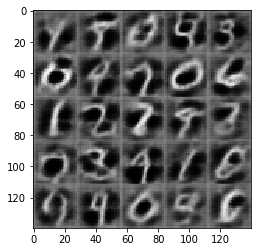

Epoch 2/2: batch 810: descriminator loss: 1.3211 generator loss: 0.5708
Epoch 2/2: batch 820: descriminator loss: 1.0568 generator loss: 1.1130
Epoch 2/2: batch 830: descriminator loss: 1.0027 generator loss: 0.8830
Epoch 2/2: batch 840: descriminator loss: 1.0501 generator loss: 0.8673
Epoch 2/2: batch 850: descriminator loss: 1.3297 generator loss: 0.6435
Epoch 2/2: batch 860: descriminator loss: 0.9450 generator loss: 1.2632
Epoch 2/2: batch 870: descriminator loss: 0.8945 generator loss: 1.1985
Epoch 2/2: batch 880: descriminator loss: 0.9310 generator loss: 1.3240
Epoch 2/2: batch 890: descriminator loss: 0.9488 generator loss: 1.6483
Epoch 2/2: batch 900: descriminator loss: 0.9601 generator loss: 1.2467


Epoch 2/2: batch 910: descriminator loss: 1.0672 generator loss: 0.8043
Epoch 2/2: batch 920: descriminator loss: 1.4898 generator loss: 0.4655
Epoch 2/2: batch 930: descriminator loss: 1.0676 generator loss: 0.9144


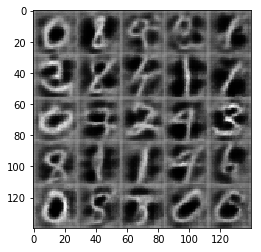

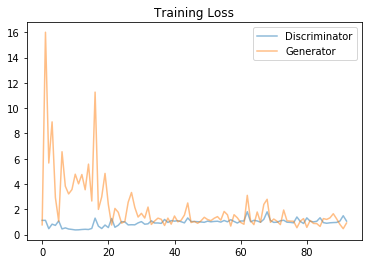

In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

    plot_losses(d_losses, g_losses)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2: batch 10: descriminator loss: 1.2623 generator loss: 0.7925
Epoch 1/2: batch 20: descriminator loss: 0.5609 generator loss: 3.2330
Epoch 1/2: batch 30: descriminator loss: 0.5097 generator loss: 2.6883
Epoch 1/2: batch 40: descriminator loss: 0.5436 generator loss: 2.0028
Epoch 1/2: batch 50: descriminator loss: 1.4553 generator loss: 13.5825
Epoch 1/2: batch 60: descriminator loss: 0.4165 generator loss: 8.3811
Epoch 1/2: batch 70: descriminator loss: 0.5719 generator loss: 2.3391
Epoch 1/2: batch 80: descriminator loss: 0.6096 generator loss: 1.8113
Epoch 1/2: batch 90: descriminator loss: 0.7969 generator loss: 8.6578
Epoch 1/2: batch 100: descriminator loss: 0.6109 generator loss: 4.4070


Epoch 1/2: batch 110: descriminator loss: 0.4965 generator loss: 3.0496
Epoch 1/2: batch 120: descriminator loss: 0.5463 generator loss: 2.4883
Epoch 1/2: batch 130: descriminator loss: 0.5049 generator loss: 2.6577
Epoch 1/2: batch 140: descriminator loss: 0.4865 generator loss: 2.7351
Epoch 1/2: batch 150: descriminator loss: 0.4975 generator loss: 2.7144
Epoch 1/2: batch 160: descriminator loss: 0.5030 generator loss: 2.6161
Epoch 1/2: batch 170: descriminator loss: 0.5593 generator loss: 1.9415
Epoch 1/2: batch 180: descriminator loss: 0.9131 generator loss: 1.0326
Epoch 1/2: batch 190: descriminator loss: 0.8430 generator loss: 2.7753
Epoch 1/2: batch 200: descriminator loss: 0.6919 generator loss: 1.3819


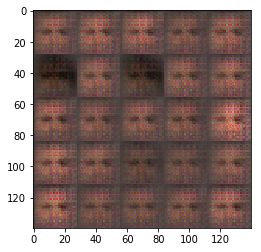

Epoch 1/2: batch 210: descriminator loss: 0.5765 generator loss: 3.5640
Epoch 1/2: batch 220: descriminator loss: 0.7408 generator loss: 1.7443
Epoch 1/2: batch 230: descriminator loss: 0.6271 generator loss: 2.8608
Epoch 1/2: batch 240: descriminator loss: 0.6992 generator loss: 2.1774
Epoch 1/2: batch 250: descriminator loss: 0.6830 generator loss: 3.1444
Epoch 1/2: batch 260: descriminator loss: 0.7940 generator loss: 2.2568
Epoch 1/2: batch 270: descriminator loss: 0.8644 generator loss: 1.5157
Epoch 1/2: batch 280: descriminator loss: 1.6205 generator loss: 4.5902
Epoch 1/2: batch 290: descriminator loss: 1.2696 generator loss: 0.9057
Epoch 1/2: batch 300: descriminator loss: 0.9313 generator loss: 1.4178


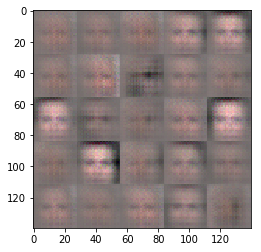

Epoch 1/2: batch 310: descriminator loss: 0.7741 generator loss: 2.4330
Epoch 1/2: batch 320: descriminator loss: 0.8002 generator loss: 1.8555
Epoch 1/2: batch 330: descriminator loss: 0.9634 generator loss: 1.1488
Epoch 1/2: batch 340: descriminator loss: 0.8662 generator loss: 1.3370
Epoch 1/2: batch 350: descriminator loss: 1.0182 generator loss: 0.9193
Epoch 1/2: batch 360: descriminator loss: 1.1094 generator loss: 1.2637
Epoch 1/2: batch 370: descriminator loss: 1.7968 generator loss: 0.4035
Epoch 1/2: batch 380: descriminator loss: 0.8170 generator loss: 2.0598
Epoch 1/2: batch 390: descriminator loss: 0.8652 generator loss: 1.6275
Epoch 1/2: batch 400: descriminator loss: 0.9878 generator loss: 0.9138


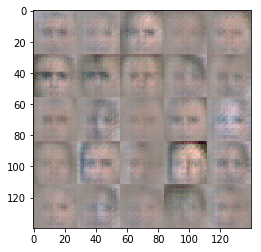

Epoch 1/2: batch 410: descriminator loss: 0.9862 generator loss: 1.6619
Epoch 1/2: batch 420: descriminator loss: 1.3403 generator loss: 0.6622
Epoch 1/2: batch 430: descriminator loss: 0.8785 generator loss: 1.5467
Epoch 1/2: batch 440: descriminator loss: 0.9779 generator loss: 1.2860
Epoch 1/2: batch 450: descriminator loss: 0.8685 generator loss: 1.3054
Epoch 1/2: batch 460: descriminator loss: 1.2398 generator loss: 0.8173
Epoch 1/2: batch 470: descriminator loss: 1.0579 generator loss: 1.0031
Epoch 1/2: batch 480: descriminator loss: 0.9907 generator loss: 1.6002
Epoch 1/2: batch 490: descriminator loss: 1.0351 generator loss: 1.4853
Epoch 1/2: batch 500: descriminator loss: 1.3213 generator loss: 0.5829


Epoch 1/2: batch 510: descriminator loss: 1.1367 generator loss: 1.6186
Epoch 1/2: batch 520: descriminator loss: 1.1418 generator loss: 0.8574
Epoch 1/2: batch 530: descriminator loss: 0.9818 generator loss: 1.6488
Epoch 1/2: batch 540: descriminator loss: 1.4088 generator loss: 0.6214
Epoch 1/2: batch 550: descriminator loss: 0.9972 generator loss: 1.6382
Epoch 1/2: batch 560: descriminator loss: 1.0596 generator loss: 2.1227
Epoch 1/2: batch 570: descriminator loss: 1.0984 generator loss: 1.1264
Epoch 1/2: batch 580: descriminator loss: 1.1465 generator loss: 0.8527
Epoch 1/2: batch 590: descriminator loss: 1.0477 generator loss: 1.0696
Epoch 1/2: batch 600: descriminator loss: 1.4516 generator loss: 0.6043


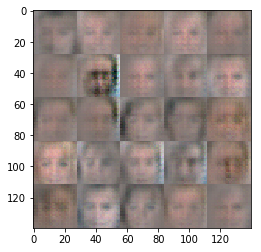

Epoch 1/2: batch 610: descriminator loss: 1.4652 generator loss: 1.8444
Epoch 1/2: batch 620: descriminator loss: 1.1445 generator loss: 1.1840
Epoch 1/2: batch 630: descriminator loss: 0.9378 generator loss: 1.7111
Epoch 1/2: batch 640: descriminator loss: 1.0651 generator loss: 1.1549
Epoch 1/2: batch 650: descriminator loss: 1.4253 generator loss: 0.6045
Epoch 1/2: batch 660: descriminator loss: 1.0501 generator loss: 1.1428
Epoch 1/2: batch 670: descriminator loss: 1.1856 generator loss: 0.9227
Epoch 1/2: batch 680: descriminator loss: 1.0410 generator loss: 1.5289
Epoch 1/2: batch 690: descriminator loss: 1.4740 generator loss: 2.1956
Epoch 1/2: batch 700: descriminator loss: 1.0135 generator loss: 1.3024


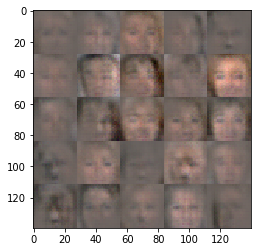

Epoch 1/2: batch 710: descriminator loss: 1.4745 generator loss: 2.3908
Epoch 1/2: batch 720: descriminator loss: 1.1109 generator loss: 1.0648
Epoch 1/2: batch 730: descriminator loss: 0.9239 generator loss: 1.2552
Epoch 1/2: batch 740: descriminator loss: 1.0847 generator loss: 1.0913
Epoch 1/2: batch 750: descriminator loss: 1.0255 generator loss: 1.0834
Epoch 1/2: batch 760: descriminator loss: 1.0665 generator loss: 1.2736
Epoch 1/2: batch 770: descriminator loss: 1.0903 generator loss: 1.3076
Epoch 1/2: batch 780: descriminator loss: 0.9852 generator loss: 1.2875
Epoch 1/2: batch 790: descriminator loss: 1.0783 generator loss: 1.3006
Epoch 2/2: batch 800: descriminator loss: 1.1274 generator loss: 1.9523


Epoch 2/2: batch 810: descriminator loss: 0.9386 generator loss: 1.3739
Epoch 2/2: batch 820: descriminator loss: 1.0278 generator loss: 1.2091
Epoch 2/2: batch 830: descriminator loss: 1.6207 generator loss: 2.7357
Epoch 2/2: batch 840: descriminator loss: 1.1902 generator loss: 0.7612
Epoch 2/2: batch 850: descriminator loss: 1.2892 generator loss: 0.6156
Epoch 2/2: batch 860: descriminator loss: 0.9324 generator loss: 1.7177
Epoch 2/2: batch 870: descriminator loss: 1.1073 generator loss: 0.7933
Epoch 2/2: batch 880: descriminator loss: 0.9268 generator loss: 1.0973
Epoch 2/2: batch 890: descriminator loss: 0.8807 generator loss: 1.1024
Epoch 2/2: batch 900: descriminator loss: 0.9723 generator loss: 1.1791


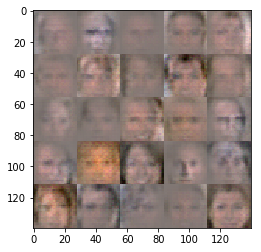

Epoch 2/2: batch 910: descriminator loss: 1.1457 generator loss: 0.7496
Epoch 2/2: batch 920: descriminator loss: 0.9832 generator loss: 1.1185
Epoch 2/2: batch 930: descriminator loss: 1.1375 generator loss: 0.7426
Epoch 2/2: batch 940: descriminator loss: 1.8054 generator loss: 3.1786
Epoch 2/2: batch 950: descriminator loss: 1.0814 generator loss: 1.2426
Epoch 2/2: batch 960: descriminator loss: 1.0907 generator loss: 0.9828
Epoch 2/2: batch 970: descriminator loss: 1.1708 generator loss: 0.9493
Epoch 2/2: batch 980: descriminator loss: 1.1066 generator loss: 0.8724
Epoch 2/2: batch 990: descriminator loss: 1.0818 generator loss: 0.9576
Epoch 2/2: batch 1000: descriminator loss: 1.3092 generator loss: 2.3705


Epoch 2/2: batch 1010: descriminator loss: 1.2672 generator loss: 0.6818
Epoch 2/2: batch 1020: descriminator loss: 0.8820 generator loss: 1.5932
Epoch 2/2: batch 1030: descriminator loss: 1.0151 generator loss: 1.2517
Epoch 2/2: batch 1040: descriminator loss: 0.9381 generator loss: 1.3653
Epoch 2/2: batch 1050: descriminator loss: 1.0805 generator loss: 1.1005
Epoch 2/2: batch 1060: descriminator loss: 1.0703 generator loss: 0.8480
Epoch 2/2: batch 1070: descriminator loss: 1.0603 generator loss: 0.9710
Epoch 2/2: batch 1080: descriminator loss: 0.8846 generator loss: 1.3951
Epoch 2/2: batch 1090: descriminator loss: 0.9465 generator loss: 1.0525
Epoch 2/2: batch 1100: descriminator loss: 0.8946 generator loss: 2.2388


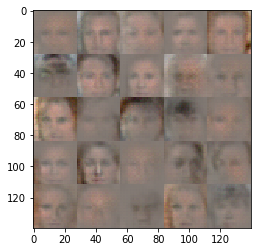

Epoch 2/2: batch 1110: descriminator loss: 0.9774 generator loss: 1.1929
Epoch 2/2: batch 1120: descriminator loss: 1.1270 generator loss: 2.9142
Epoch 2/2: batch 1130: descriminator loss: 1.1572 generator loss: 1.4253
Epoch 2/2: batch 1140: descriminator loss: 1.0707 generator loss: 0.8751
Epoch 2/2: batch 1150: descriminator loss: 1.1279 generator loss: 1.0072
Epoch 2/2: batch 1160: descriminator loss: 2.3473 generator loss: 3.6935
Epoch 2/2: batch 1170: descriminator loss: 1.1395 generator loss: 0.8600
Epoch 2/2: batch 1180: descriminator loss: 0.9958 generator loss: 1.8192
Epoch 2/2: batch 1190: descriminator loss: 1.0027 generator loss: 2.9434
Epoch 2/2: batch 1200: descriminator loss: 1.2163 generator loss: 3.2356


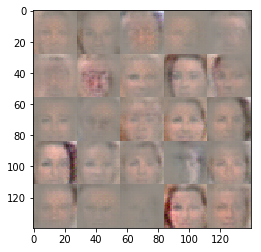

Epoch 2/2: batch 1210: descriminator loss: 0.9606 generator loss: 1.1006
Epoch 2/2: batch 1220: descriminator loss: 1.3795 generator loss: 0.5827
Epoch 2/2: batch 1230: descriminator loss: 1.1947 generator loss: 1.2557
Epoch 2/2: batch 1240: descriminator loss: 0.8672 generator loss: 1.8671
Epoch 2/2: batch 1250: descriminator loss: 0.8238 generator loss: 2.2693
Epoch 2/2: batch 1260: descriminator loss: 1.0648 generator loss: 2.0038
Epoch 2/2: batch 1270: descriminator loss: 1.2343 generator loss: 0.6673
Epoch 2/2: batch 1280: descriminator loss: 0.8565 generator loss: 1.4060
Epoch 2/2: batch 1290: descriminator loss: 0.6902 generator loss: 2.2005
Epoch 2/2: batch 1300: descriminator loss: 0.7067 generator loss: 1.8888


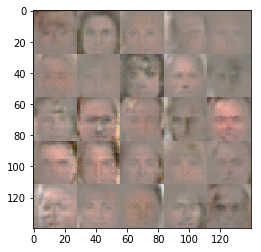

Epoch 2/2: batch 1310: descriminator loss: 0.9857 generator loss: 0.9913
Epoch 2/2: batch 1320: descriminator loss: 1.1909 generator loss: 0.7095
Epoch 2/2: batch 1330: descriminator loss: 1.0175 generator loss: 1.7971
Epoch 2/2: batch 1340: descriminator loss: 0.7669 generator loss: 2.5374
Epoch 2/2: batch 1350: descriminator loss: 1.0215 generator loss: 2.5857
Epoch 2/2: batch 1360: descriminator loss: 1.0467 generator loss: 0.8120
Epoch 2/2: batch 1370: descriminator loss: 0.7090 generator loss: 2.3302
Epoch 2/2: batch 1380: descriminator loss: 1.2798 generator loss: 0.6141
Epoch 2/2: batch 1390: descriminator loss: 1.2624 generator loss: 0.7311
Epoch 2/2: batch 1400: descriminator loss: 1.1112 generator loss: 1.1838


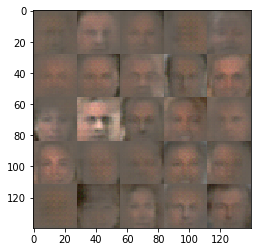

Epoch 2/2: batch 1410: descriminator loss: 0.9886 generator loss: 1.0448
Epoch 2/2: batch 1420: descriminator loss: 1.2572 generator loss: 0.6339
Epoch 2/2: batch 1430: descriminator loss: 1.1441 generator loss: 0.8282
Epoch 2/2: batch 1440: descriminator loss: 0.9118 generator loss: 1.1738
Epoch 2/2: batch 1450: descriminator loss: 1.0548 generator loss: 0.8536
Epoch 2/2: batch 1460: descriminator loss: 0.9310 generator loss: 1.4360
Epoch 2/2: batch 1470: descriminator loss: 0.9427 generator loss: 1.3470
Epoch 2/2: batch 1480: descriminator loss: 1.1013 generator loss: 0.8704
Epoch 2/2: batch 1490: descriminator loss: 1.5958 generator loss: 0.4114
Epoch 2/2: batch 1500: descriminator loss: 1.0635 generator loss: 1.0721


Epoch 2/2: batch 1510: descriminator loss: 0.9360 generator loss: 1.3145
Epoch 2/2: batch 1520: descriminator loss: 1.1538 generator loss: 0.7053
Epoch 2/2: batch 1530: descriminator loss: 1.4955 generator loss: 0.4667
Epoch 2/2: batch 1540: descriminator loss: 1.2294 generator loss: 1.9950
Epoch 2/2: batch 1550: descriminator loss: 0.9916 generator loss: 2.1995
Epoch 2/2: batch 1560: descriminator loss: 1.2185 generator loss: 0.6449
Epoch 2/2: batch 1570: descriminator loss: 1.0081 generator loss: 1.4679
Epoch 2/2: batch 1580: descriminator loss: 0.9496 generator loss: 1.0245


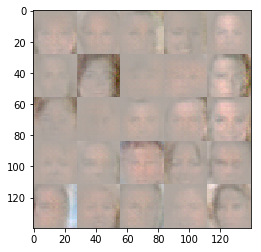

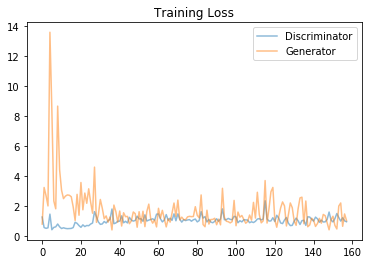

In [18]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    
    plot_losses(d_losses, g_losses)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.